In [75]:
import pandas as pd                 # for manipulating data
import pcdl                         # physicell data loader library
# import os, sys, subprocess
import math, os, sys, re
import os.path
import glob
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
import xml.etree.ElementTree as ET  # for accessing PhysiCell_settings.xml
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pcdl
import seaborn as sns

In [4]:
input_dir = "../output"
mcds_ts = pcdl.TimeSeries(input_dir, microenv=True, settingxml="PhysiCell_settings.xml", graph=False, verbose=False)

Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['drug_threshold', 'intervention_induced_apoptosis', 'proliferation_multiplier']
Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['drug_threshold', 'intervention_induced_apoptosis', 'proliferation_multiplier']
Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['drug_threshold', 'intervention_induced_apoptosis', 'proliferation_multiplier']
Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['drug_threshold', 'intervention_induced_apoptosis', 'proliferation_multiplier']
Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['drug_threshold', 'intervention_induced_apoptosis', 'proliferation_multiplier']
Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['drug_thresh

In [ ]:
# load PhysiCell_settings xml file - ONLY needed for video creation
xml_path = path + "PhysiCell_settings.xml"
xml = open(xml_path)
tree = ET.parse(xml)
xml_root = tree.getroot()

In [79]:
# print(mcds_ts.get_mcds_list()[0]) # you get a "pyMCDS" object. Then from there, you can do pyMCDS.get_cell_df() to get a pandas dataframe of the cells (for exmaple)

mcds_ts.get_mcds_list()[0].get_cell_df().head() # brilliant
mcds = mcds_ts.get_mcds_list()[-1]
conc_df = mcds.get_conc_df() # also brilliant - first substrate willl always be ... 7th column (0-indexed)
substrate_name = conc_df.columns[6] # gives me the substrate name
mcds.get_concentration(substrate_name)
xx, yy = mcds.get_mesh_2D()
substrate = mcds.get_concentration(substrate)


In [101]:
# convereted from https://github.com/PhysiCell-Models/collective-invasion/blob/master/python_imaging/image_processing_for_physicell.py
# I coud probably do several - or just use that code. Not sure whats eaiser ... 

def create_contour_plot(fig, ax, x_mesh: dict, y_mesh: dict, data_to_contour: dict, contour_options=None, options: dict=None):
    ### best options are probably to just allow defaults, search for max and min for limits, or maybe insist on limits ...
    ### another obvious option - and this coudl be a global to reset ... you could even change it with function calls
    ### countour color maps ...

    if contour_options is None:
        cs = ax.contourf(x_mesh, y_mesh, data_to_contour, cmap="Reds")
        fig.colorbar(cs, ax=ax)
        # self.fig.show()
    else:

        if 'alpha' not in contour_options.keys():
            contour_options['alpha'] = 1.0     

        # Make levels for contours
        contour_spacing = np.linspace(contour_options['lowest_contour'], contour_options['upper_contour'], contour_options['number_of_levels'])

        cs = ax.contourf(x_mesh, y_mesh, data_to_contour, cmap=contour_options['color_map_name'], levels=contour_spacing, alpha=contour_options['alpha'])
        if contour_options['color_bar'] is True:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.10)
            # other fancy things you can do with colorbars - https://stackoverflow.com/questions/16595138/standalone-colorbar-matplotlib
            if options is None:
                cb = fig.colorbar(cs, cax=cax, format='%.3f')
            elif options['produce_for_panel'] is False:
                cb = fig.colorbar(cs, cax=cax, format='%.3f')
            else:
                tick_spacing = np.linspace(contour_options['lowest_contour'], contour_options['upper_contour'], 5)
                cb = fig.colorbar(cs, cax=cax, format='%.2f', ticks=tick_spacing)
                cb.ax.tick_params(labelsize=20)

In [104]:
contour_options = {'lowest_contour': 0.0, ### I woud like this to be cleaner - but it does work!!!
                    'upper_contour': 1.0,
                    'number_of_levels': 100,
                    'color_map_name': 'Reds',
                    'color_bar': True
                    }

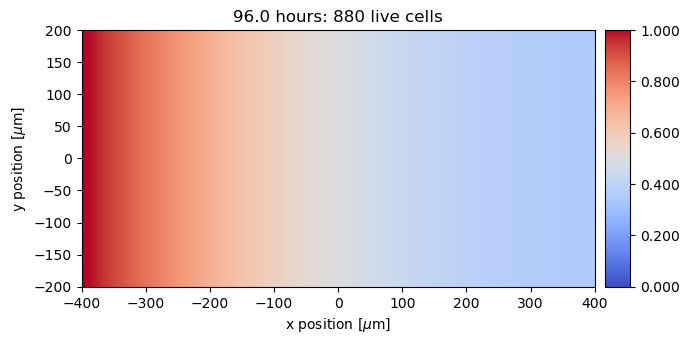

In [140]:
fig, ax = plt.subplots(figsize = (7, 4))

cell_df = mcds.get_cell_df()

number_of_live_cells = len(cell_df[cell_df['dead'] == False])
time = mcds.get_time()
time = time/60 # (convert to hours)

# iN theory these oculd be set once - don't worr yabout it. 

plot_extend = mcds.get_mesh_mnp_range() # returns in a list of tuples the lowest and highest x-axis, y-axis, and z-axis mesh center value.

# This assumes dx = dy = 20

# substrate
conc_df = mcds.get_conc_df() # also brilliant - first substrate willl always be ... 7th column (0-indexed)
substrate = conc_df.columns[6] # gives me the substrate name

xx, yy = mcds.get_mesh_2D()
substrate_conc_grid = mcds.get_concentration(substrate, 0.0)
# create_contour_plot(fig, ax, xx, yy, substrate_conc_grid, contour_options=contour_options, options=None)

# no smoothing
# ax.imshow(substrate_conc_grid, cmap='Reds', origin='lower', extent=[xx.min()-10, xx.max()-10, yy.min()-10, yy.max()+10])
substrate_im = ax.imshow(substrate_conc_grid, cmap='coolwarm', interpolation='bicubic', origin='lower', vmin=0, vmax=1, 
          extent=[xx.min()-10, xx.max()+10, yy.min()-10, yy.max()+10])

# Cells
for cell in cell_df.itertuples(): # iterrows iterate over the rows of the dataframe: returns a tuple of (index, pandas.core.series.Series). For the cells this is 119 members long \\
                                # if we don't want to iterate over the index, we can use cell_df.itertuples() instead
    # print(cell[1]['position_x'])
    # print(type(cell.position_x))
    circ_nucleus = Circle((cell.position_x, cell.position_y), radius=cell.nuclear_radius, color='purple', alpha=0.5)
    circ_cytoplasm = Circle((cell.position_x, cell.position_y), radius=cell.radius, color='purple', alpha=0.1)
    ax.add_artist(circ_cytoplasm)
    ax.add_artist(circ_nucleus)
    # ax.scatter(cell.position_x, cell.position_y, s=cell.radius, color='blue', alpha=0.7)
    ax.set_aspect('equal')


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cb = fig.colorbar(substrate_im, cax=cax, format='%.3f')
# # other fancy things you can do with colorbars - https://stackoverflow.com/questions/16595138/standalone-colorbar-matplotlib
# if options is None:
#     cb = fig.colorbar(substrate_im, cax=cax, format='%.3f')
# elif options['produce_for_panel'] is False:
#     cb = fig.colorbar(substrate_im, cax=cax, format='%.3f')
# else:
#     tick_spacing = np.linspace(contour_options['lowest_contour'], contour_options['upper_contour'], 5)
#     cb = fig.colorbar(substrate_im, cax=cax, format='%.2f', ticks=tick_spacing)
#     cb.ax.tick_params(labelsize=20)



ax.set_xlabel('x position [$\mu$m]')
ax.set_ylabel('y position [$\mu$m]')
ax.set_title(str(time) + ' hours: ' + str(number_of_live_cells) + ' live cells')

neg_plot_x_extend = plot_extend[0][0] - 10
pos_plot_x_extend = plot_extend[0][1] + 10
neg_plot_y_extend = plot_extend[1][0] - 10
pos_plot_y_extend = plot_extend[1][1] + 10
ax.set_xlim(neg_plot_x_extend, pos_plot_x_extend)
ax.set_ylim(neg_plot_y_extend, pos_plot_y_extend)
plt.tight_layout()
    # print(cell['position_x'])
                    # circ = Circle((plot_df.loc[j, 'position_x'], plot_df.loc[j, 'position_y']),
                    #           radius=plot_df.loc[j, 'radius'], color=colors[i], alpha=0.7)
    # ax.add_artist(plt.Circle((cell.position_x, cell.position_y), radius=cell.radius, edgecolor = 'black', fill = True, color = 'blue'))
# for idx, cell in cell_df.iterrows():
#     ax.add_artist(plt.Circle((cell['position_x'], cell['position_y']), cell['radius'], edgecolor = 'black', fill = True, color = 'blue'))

In [3]:
################## Pathing Variables ########################

# relative path to input directory
# EDIT TO BE LOCATION OF ORIGINAL MODEL FILES
rel_input_dir = 'leukemia_output/'

# relative path to output directory
# EDIT TO BE LOCATION OF WHERE YOU WANT TO STORE THE NEW MODEL FILES
rel_output_dir = 'dataframes/'

########################### PATHING ###########################
# move to PhysiCell root directory - this assumes this script is one folder below the root
os.chdir("../")
full_path = os.getcwd()
print(full_path)

# INPUTS
input_dir = os.path.join(full_path, rel_input_dir)
print("Input directory: ")
print(input_dir)

# OUTPUTS
output_dir = os.path.join(full_path, rel_output_dir)
print("Output directory: ")
print(output_dir)

/Users/JohnMetzcar/Documents/GitHub/PhysiLab
Input directory: 
/Users/JohnMetzcar/Documents/GitHub/PhysiLab/leukemia_output/
Output directory: 
/Users/JohnMetzcar/Documents/GitHub/PhysiLab/dataframes/


In [33]:
# make sure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# list of intervention names
interventions = [f.name for f in os.scandir(input_dir) if f.is_dir()] 
interventions = sorted(interventions)
interventions

['EG_Ceramide_S1P_1_11',
 'EG_Ceramide_S1P_1_12',
 'EG_Ceramide_S1P_1_13',
 'EG_Ceramide_S1P_1_21',
 'EG_Ceramide_S1P_1_22',
 'EG_Ceramide_S1P_1_23',
 'EG_Ceramide_S1P_1_31',
 'EG_Ceramide_S1P_1_32',
 'EG_Ceramide_S1P_1_33',
 'EG_GAP_RAS_1_11',
 'EG_GAP_RAS_1_12',
 'EG_GAP_RAS_1_13',
 'EG_GAP_RAS_1_21',
 'EG_GAP_RAS_1_22',
 'EG_GAP_RAS_1_23',
 'EG_GAP_RAS_1_31',
 'EG_GAP_RAS_1_32',
 'EG_GAP_RAS_1_33',
 'EG_IL15_GAP_0_11',
 'EG_IL15_GAP_0_12',
 'EG_IL15_GAP_0_13',
 'EG_IL15_GAP_0_21',
 'EG_IL15_GAP_0_22',
 'EG_IL15_GAP_0_23',
 'EG_IL15_GAP_0_31',
 'EG_IL15_GAP_0_32',
 'EG_IL15_GAP_0_33',
 'EG_IL2RBT_IL2RB_0_11',
 'EG_IL2RBT_IL2RB_0_12',
 'EG_IL2RBT_IL2RB_0_13',
 'EG_IL2RBT_IL2RB_0_21',
 'EG_IL2RBT_IL2RB_0_22',
 'EG_IL2RBT_IL2RB_0_23',
 'EG_IL2RBT_IL2RB_0_31',
 'EG_IL2RBT_IL2RB_0_32',
 'EG_IL2RBT_IL2RB_0_33',
 'EG_IL2RB_MCL1_0_11',
 'EG_IL2RB_MCL1_0_12',
 'EG_IL2RB_MCL1_0_13',
 'EG_IL2RB_MCL1_0_21',
 'EG_IL2RB_MCL1_0_22',
 'EG_IL2RB_MCL1_0_23',
 'EG_IL2RB_MCL1_0_31',
 'EG_IL2RB_MCL1_0_32

In [34]:
# for each intervention
for i, intervention in enumerate(interventions):
    # create filepath
    path = input_dir + intervention

    # create a timeseries object
    mcds_ts = pcdl.TimeSeries(path)

    # create dictionary for this intervention
    # keys = time t; values = # live cells at time t
    data = {'intervention': interventions[i]}
    for mcds in mcds_ts.get_mcds_list():
        df_cell = mcds.get_cell_df()
        live_cells =len(df_cell[(df_cell['dead'] == False)])
        data[mcds.get_time()] = live_cells
    
    if (i == 0): df = pd.DataFrame([data])  # create the dataframe
    else: df.loc[len(df)] = data            # append the dictionary to the dataframe

# for root, dirs, files in interventions:
#     for name in files:
#         print(name)
#     for name in dirs:
#         print(name)

reading: /Users/JohnMetzcar/Documents/GitHub/PhysiLab/leukemia_output/EG_IL2RB_MCL1_0_11/PhysiCell_settings.xml
Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['drug_threshold', 'intervention_induced_apoptosis', 'proliferation_multiplier']
reading: /Users/JohnMetzcar/Documents/GitHub/PhysiLab/leukemia_output/EG_IL2RB_MCL1_0_11/output00000000.xml
working on metadata ...
working on mesh data ...
reading: /Users/JohnMetzcar/Documents/GitHub/PhysiLab/leukemia_output/EG_IL2RB_MCL1_0_11/initial_mesh0.mat
working on microenvironment data ...
reading: /Users/JohnMetzcar/Documents/GitHub/PhysiLab/leukemia_output/EG_IL2RB_MCL1_0_11/output00000000_microenvironment0.mat
parsing: anti_IL2RB_MCL1 data
working on discrete cell data ...
reading: /Users/JohnMetzcar/Documents/GitHub/PhysiLab/leukemia_output/EG_IL2RB_MCL1_0_11/output00000000_cells.mat
working on graph data ...
reading: /Users/JohnMetzcar/Documents/GitHub/PhysiLab/leukemia_output/EG_IL2RB_

In [36]:
df.to_csv(output_dir + 'live_cells.csv', index=False)  # save the dataframe to a csv file

In [37]:
pd.read_csv(output_dir + 'live_cells.csv')  # read the csv file to check that it saved correctly

,intervention
0,EG_Ceramide_S1P_1_11
1,EG_Ceramide_S1P_1_12
2,EG_Ceramide_S1P_1_13
3,EG_Ceramide_S1P_1_21
4,EG_Ceramide_S1P_1_22
...,...
274,SM_pro_TBETpro_Ceramidepro_ERK_22
275,SM_pro_TBETpro_Ceramidepro_ERK_23
276,SM_pro_TBETpro_Ceramidepro_ERK_31
277,SM_pro_TBETpro_Ceramidepro_ERK_32
